In [2]:
# NYC Taxi and Limousine Commission
# TLC Trip Record Data
# https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-04.parquet

In [3]:
# !pip install pyarrow

In [4]:
# !pip install fpdf

In [5]:
# !pip install pandas numpy scikit-learn matplotlib seaborn

In [6]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [7]:
# Configuración para desactivar la notación científica
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

In [8]:
df = pq.read_table('./NYC - Trip Records/yellow_tripdata_2024-04.parquet')
df = df.to_pandas()

In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-04-01 00:02:40,2024-04-01 00:30:42,0.00,5.20,1.00,N,161,7,1,29.60,3.50,0.50,8.65,0.00,1.00,43.25,2.50,0.00
1,2,2024-04-01 00:41:12,2024-04-01 00:55:29,1.00,5.60,1.00,N,264,264,1,25.40,1.00,0.50,10.00,0.00,1.00,37.90,0.00,0.00
2,2,2024-04-01 00:48:42,2024-04-01 01:05:30,1.00,3.55,1.00,N,186,236,1,20.50,1.00,0.50,5.10,0.00,1.00,30.60,2.50,0.00
3,2,2024-04-01 00:56:02,2024-04-01 01:05:09,1.00,1.06,1.00,N,137,164,2,10.00,1.00,0.50,0.00,0.00,1.00,15.00,2.50,0.00
4,1,2024-04-01 00:08:32,2024-04-01 00:10:24,1.00,0.70,1.00,N,236,263,1,5.10,3.50,0.50,2.00,0.00,1.00,12.10,2.50,0.00


In [10]:
df.count()

VendorID                 3514289
tpep_pickup_datetime     3514289
tpep_dropoff_datetime    3514289
passenger_count          3105713
trip_distance            3514289
RatecodeID               3105713
store_and_fwd_flag       3105713
PULocationID             3514289
DOLocationID             3514289
payment_type             3514289
fare_amount              3514289
extra                    3514289
mta_tax                  3514289
tip_amount               3514289
tolls_amount             3514289
improvement_surcharge    3514289
total_amount             3514289
congestion_surcharge     3105713
Airport_fee              3105713
dtype: int64

In [11]:
# LocationID,Borough,Zone,service_zone
# 138,"Queens","LaGuardia Airport","Airports"
query = 'PULocationID == 138'
df = df.query(query)
df.count()

VendorID                 111164
tpep_pickup_datetime     111164
tpep_dropoff_datetime    111164
passenger_count          110553
trip_distance            111164
RatecodeID               110553
store_and_fwd_flag       110553
PULocationID             111164
DOLocationID             111164
payment_type             111164
fare_amount              111164
extra                    111164
mta_tax                  111164
tip_amount               111164
tolls_amount             111164
improvement_surcharge    111164
total_amount             111164
congestion_surcharge     110553
Airport_fee              110553
dtype: int64

In [12]:
zone_file_path = './NYC - Trip Records/taxi_zone_lookup.csv'
zones_df = pd.read_csv(zone_file_path)

df = df.merge(zones_df, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_pickup'))
df = df.merge(zones_df, how='left', left_on='DOLocationID', right_on='LocationID', suffixes=('', '_dropoff'))

df.drop(columns=['LocationID', 'LocationID_dropoff'], inplace=True)

In [13]:
query = ' Borough_dropoff == "Manhattan" '
df = df.query(query)

In [14]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Borough,Zone,service_zone,Borough_dropoff,Zone_dropoff,service_zone_dropoff
1,2,2024-04-01 00:21:38,2024-04-01 00:36:02,1.00,7.76,1.00,N,138,263,2,...,1.00,48.99,2.50,1.75,Queens,LaGuardia Airport,Airports,Manhattan,Yorkville West,Yellow Zone
2,1,2024-04-01 00:04:50,2024-04-01 00:23:32,1.00,11.50,1.00,N,138,24,1,...,1.00,72.54,0.00,1.75,Queens,LaGuardia Airport,Airports,Manhattan,Bloomingdale,Yellow Zone
5,1,2024-04-01 00:02:28,2024-04-01 00:19:23,1.00,9.70,1.00,N,138,237,1,...,1.00,64.28,2.50,1.75,Queens,LaGuardia Airport,Airports,Manhattan,Upper East Side South,Yellow Zone
7,2,2024-04-01 00:01:06,2024-04-01 00:22:48,2.00,10.22,1.00,N,138,239,1,...,1.00,70.19,2.50,1.75,Queens,LaGuardia Airport,Airports,Manhattan,Upper West Side South,Yellow Zone
9,2,2024-04-01 00:18:35,2024-04-01 00:36:08,1.00,9.40,1.00,N,138,233,1,...,1.00,66.84,2.50,1.75,Queens,LaGuardia Airport,Airports,Manhattan,UN/Turtle Bay South,Yellow Zone


In [15]:
df.count()

VendorID                 77870
tpep_pickup_datetime     77870
tpep_dropoff_datetime    77870
passenger_count          77348
trip_distance            77870
RatecodeID               77348
store_and_fwd_flag       77348
PULocationID             77870
DOLocationID             77870
payment_type             77870
fare_amount              77870
extra                    77870
mta_tax                  77870
tip_amount               77870
tolls_amount             77870
improvement_surcharge    77870
total_amount             77870
congestion_surcharge     77348
Airport_fee              77348
Borough                  77870
Zone                     77870
service_zone             77870
Borough_dropoff          77870
Zone_dropoff             77870
service_zone_dropoff     77870
dtype: int64

In [16]:
df = df.dropna()

In [17]:
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)
df['payment_type'] = df['payment_type'].fillna(1)
df['passenger_count'] = df['passenger_count'].fillna(1)
df['RatecodeID'] = df['RatecodeID'].fillna(1)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna('N')
df['Airport_fee'] = df['Airport_fee'].fillna(0)

In [18]:
nan_columns = df.columns[df.isna().any()].tolist()
print(f'Columnas con NaNs: {nan_columns}')
print(df[df.isna().any(axis=1)])

Columnas con NaNs: []
Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, Airport_fee, Borough, Zone, service_zone, Borough_dropoff, Zone_dropoff, service_zone_dropoff]
Index: []

[0 rows x 25 columns]


In [19]:
df['trip_duration_seconds'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()

df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['dropoff_date'] = df['tpep_dropoff_datetime'].dt.date

df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.day

df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
df['pickup_second'] = df['tpep_pickup_datetime'].dt.second

df['dropoff_day_of_week'] = df['tpep_dropoff_datetime'].dt.dayofweek
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour
df['dropoff_minute'] = df['tpep_dropoff_datetime'].dt.minute
df['dropoff_second'] = df['tpep_dropoff_datetime'].dt.second

df['pickup_time'] = df['pickup_hour'].astype(str).str.zfill(2) + ':' + df['pickup_minute'].astype(str).str.zfill(2)
df['dropoff_time'] = df['dropoff_hour'].astype(str).str.zfill(2) + ':' + df['dropoff_minute'].astype(str).str.zfill(2)

df['day_change'] = (df['tpep_pickup_datetime'].dt.date != df['tpep_dropoff_datetime'].dt.date).astype(int)

In [20]:
df.loc[:, 'misc_charges'] = (
    df['extra'] + 
    df['mta_tax'] + 
    df['improvement_surcharge'] + 
    df['tolls_amount'] + 
    df['congestion_surcharge'] +
    df['Airport_fee']    
)

In [21]:
df.loc[:, 'total_amount_calc'] = (df['fare_amount'] + df['extra'] + df['mta_tax'] + df['improvement_surcharge'] + df['tip_amount'] + df['tolls_amount'] + df['congestion_surcharge'] + df['Airport_fee'])

In [22]:
df['total_amount_diff'] = df['total_amount_calc'] - df['total_amount']

In [23]:
df['tip_percent'] = (df['tip_amount'] / df['fare_amount']) * 100
df['misc_charges_percent'] = (df['misc_charges'] / df['fare_amount']) * 100
df['trip_duration_minutes'] = df['trip_duration_seconds'] / 60.00
df['pickup_hour_in_minutes'] = df['pickup_hour'] * 60 + df['pickup_minute'] + df['pickup_second'] / 60.00    

In [24]:
# Limpiar registros con datos inválidos, valores negativos
query = ' trip_distance > 0 '
query += ' and tip_amount >= 0 '
query += ' and extra >= 0 '
query += ' and mta_tax >= 0 '
query += ' and tolls_amount >= 0'
query += ' and improvement_surcharge >= 0'
query += ' and congestion_surcharge >= 0'
query += ' and trip_duration_seconds > 0'
query += ' and fare_amount > 0'
query += ' and total_amount > 0' 

df = df.query(query)

In [25]:
# Limpiar registros con datos inválidos, valores negativos y fuera de rango en el limite superior
query = ' trip_distance <= 50 '
query += ' and trip_duration_minutes <= 120'
query += ' and total_amount <= 600 '
query += ' and fare_amount <= 600 '

df = df.query(query)

In [26]:
query = 'trip_distance >= 5'
df = df.query(query)

In [27]:
df.count()

VendorID                  76678
tpep_pickup_datetime      76678
tpep_dropoff_datetime     76678
passenger_count           76678
trip_distance             76678
RatecodeID                76678
store_and_fwd_flag        76678
PULocationID              76678
DOLocationID              76678
payment_type              76678
fare_amount               76678
extra                     76678
mta_tax                   76678
tip_amount                76678
tolls_amount              76678
improvement_surcharge     76678
total_amount              76678
congestion_surcharge      76678
Airport_fee               76678
Borough                   76678
Zone                      76678
service_zone              76678
Borough_dropoff           76678
Zone_dropoff              76678
service_zone_dropoff      76678
trip_duration_seconds     76678
pickup_date               76678
dropoff_date              76678
pickup_day                76678
dropoff_day               76678
pickup_day_of_week        76678
pickup_h

In [49]:
df.to_csv('./csv/subset_yellow_tripdata_2024-04.csv', index=False)

In [29]:
def descriptive_stats(df, variables):
    stats = {}
    for var in variables:
        stats[var] = {
            'Min': df[var].min(),
            'Max': df[var].max(),
            'Median': df[var].median(),
            'Mode': df[var].mode()[0],
            'Mean': df[var].mean(),
            'Std': df[var].std(),
            'Count': df[var].count()
        }
    return pd.DataFrame(stats)

In [30]:
# Seleccionar variables relevantes
variables_graficar = [
    'trip_distance',
    'trip_duration_minutes',
    'pickup_hour_in_minutes',

    'pickup_day',
    'pickup_day_of_week',
    'pickup_hour',
    
    'PULocationID',
    'DOLocationID',
    'VendorID',
    'payment_type',
    'RatecodeID',
    'passenger_count',

    'fare_amount',
    'tip_amount',
    'tip_percent',
    'misc_charges',
    'misc_charges_percent',

    'total_amount_calc'
]

In [31]:
# Seleccionar variables relevantes
variables_x_regresion = [
    'trip_distance',
    'trip_duration_minutes',
    'pickup_hour_in_minutes',
    'pickup_day',
    'pickup_day_of_week',
    'DOLocationID',
    'VendorID',
    'payment_type',
    'RatecodeID',
    'passenger_count'
]

variable_y_regresion = 'total_amount_calc'

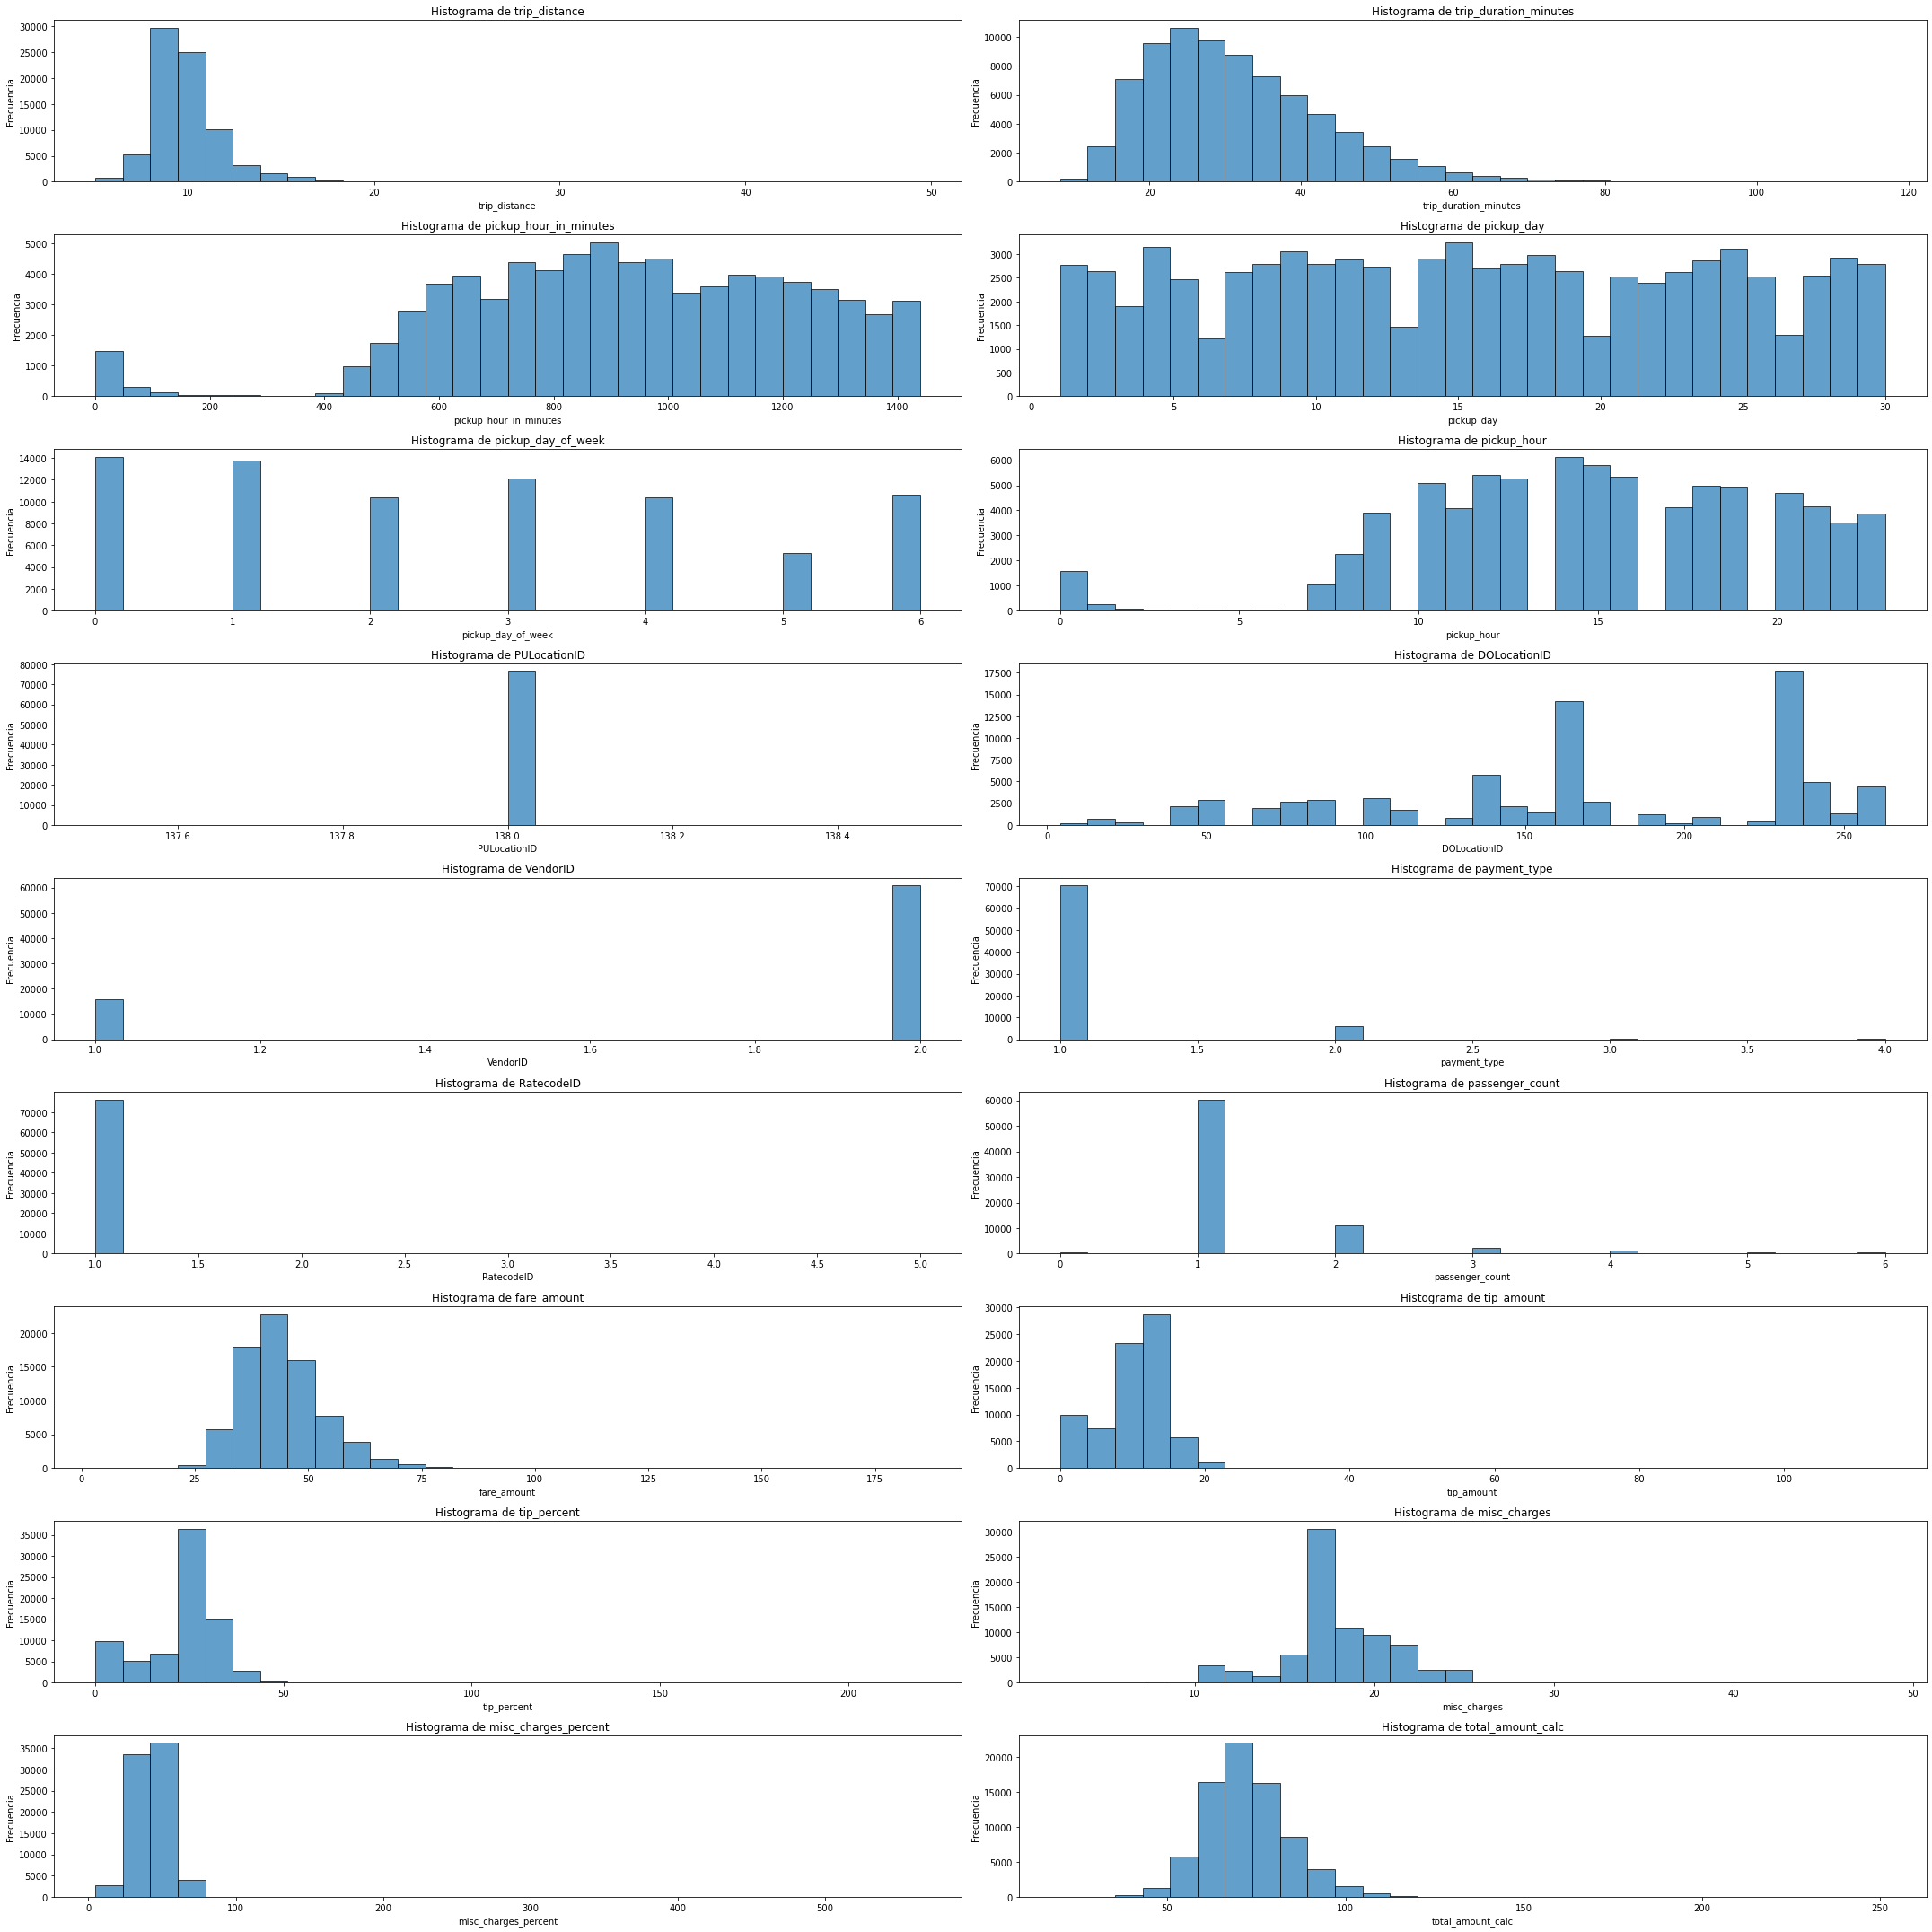

In [32]:
# Análisis exploratorio: Graficar histogramas para cada variable
plt.figure(figsize=(30, 30))

n_cols = 2
n_rows = -(-len(variables_graficar) // n_cols)

for i, var in enumerate(variables_graficar, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[var].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

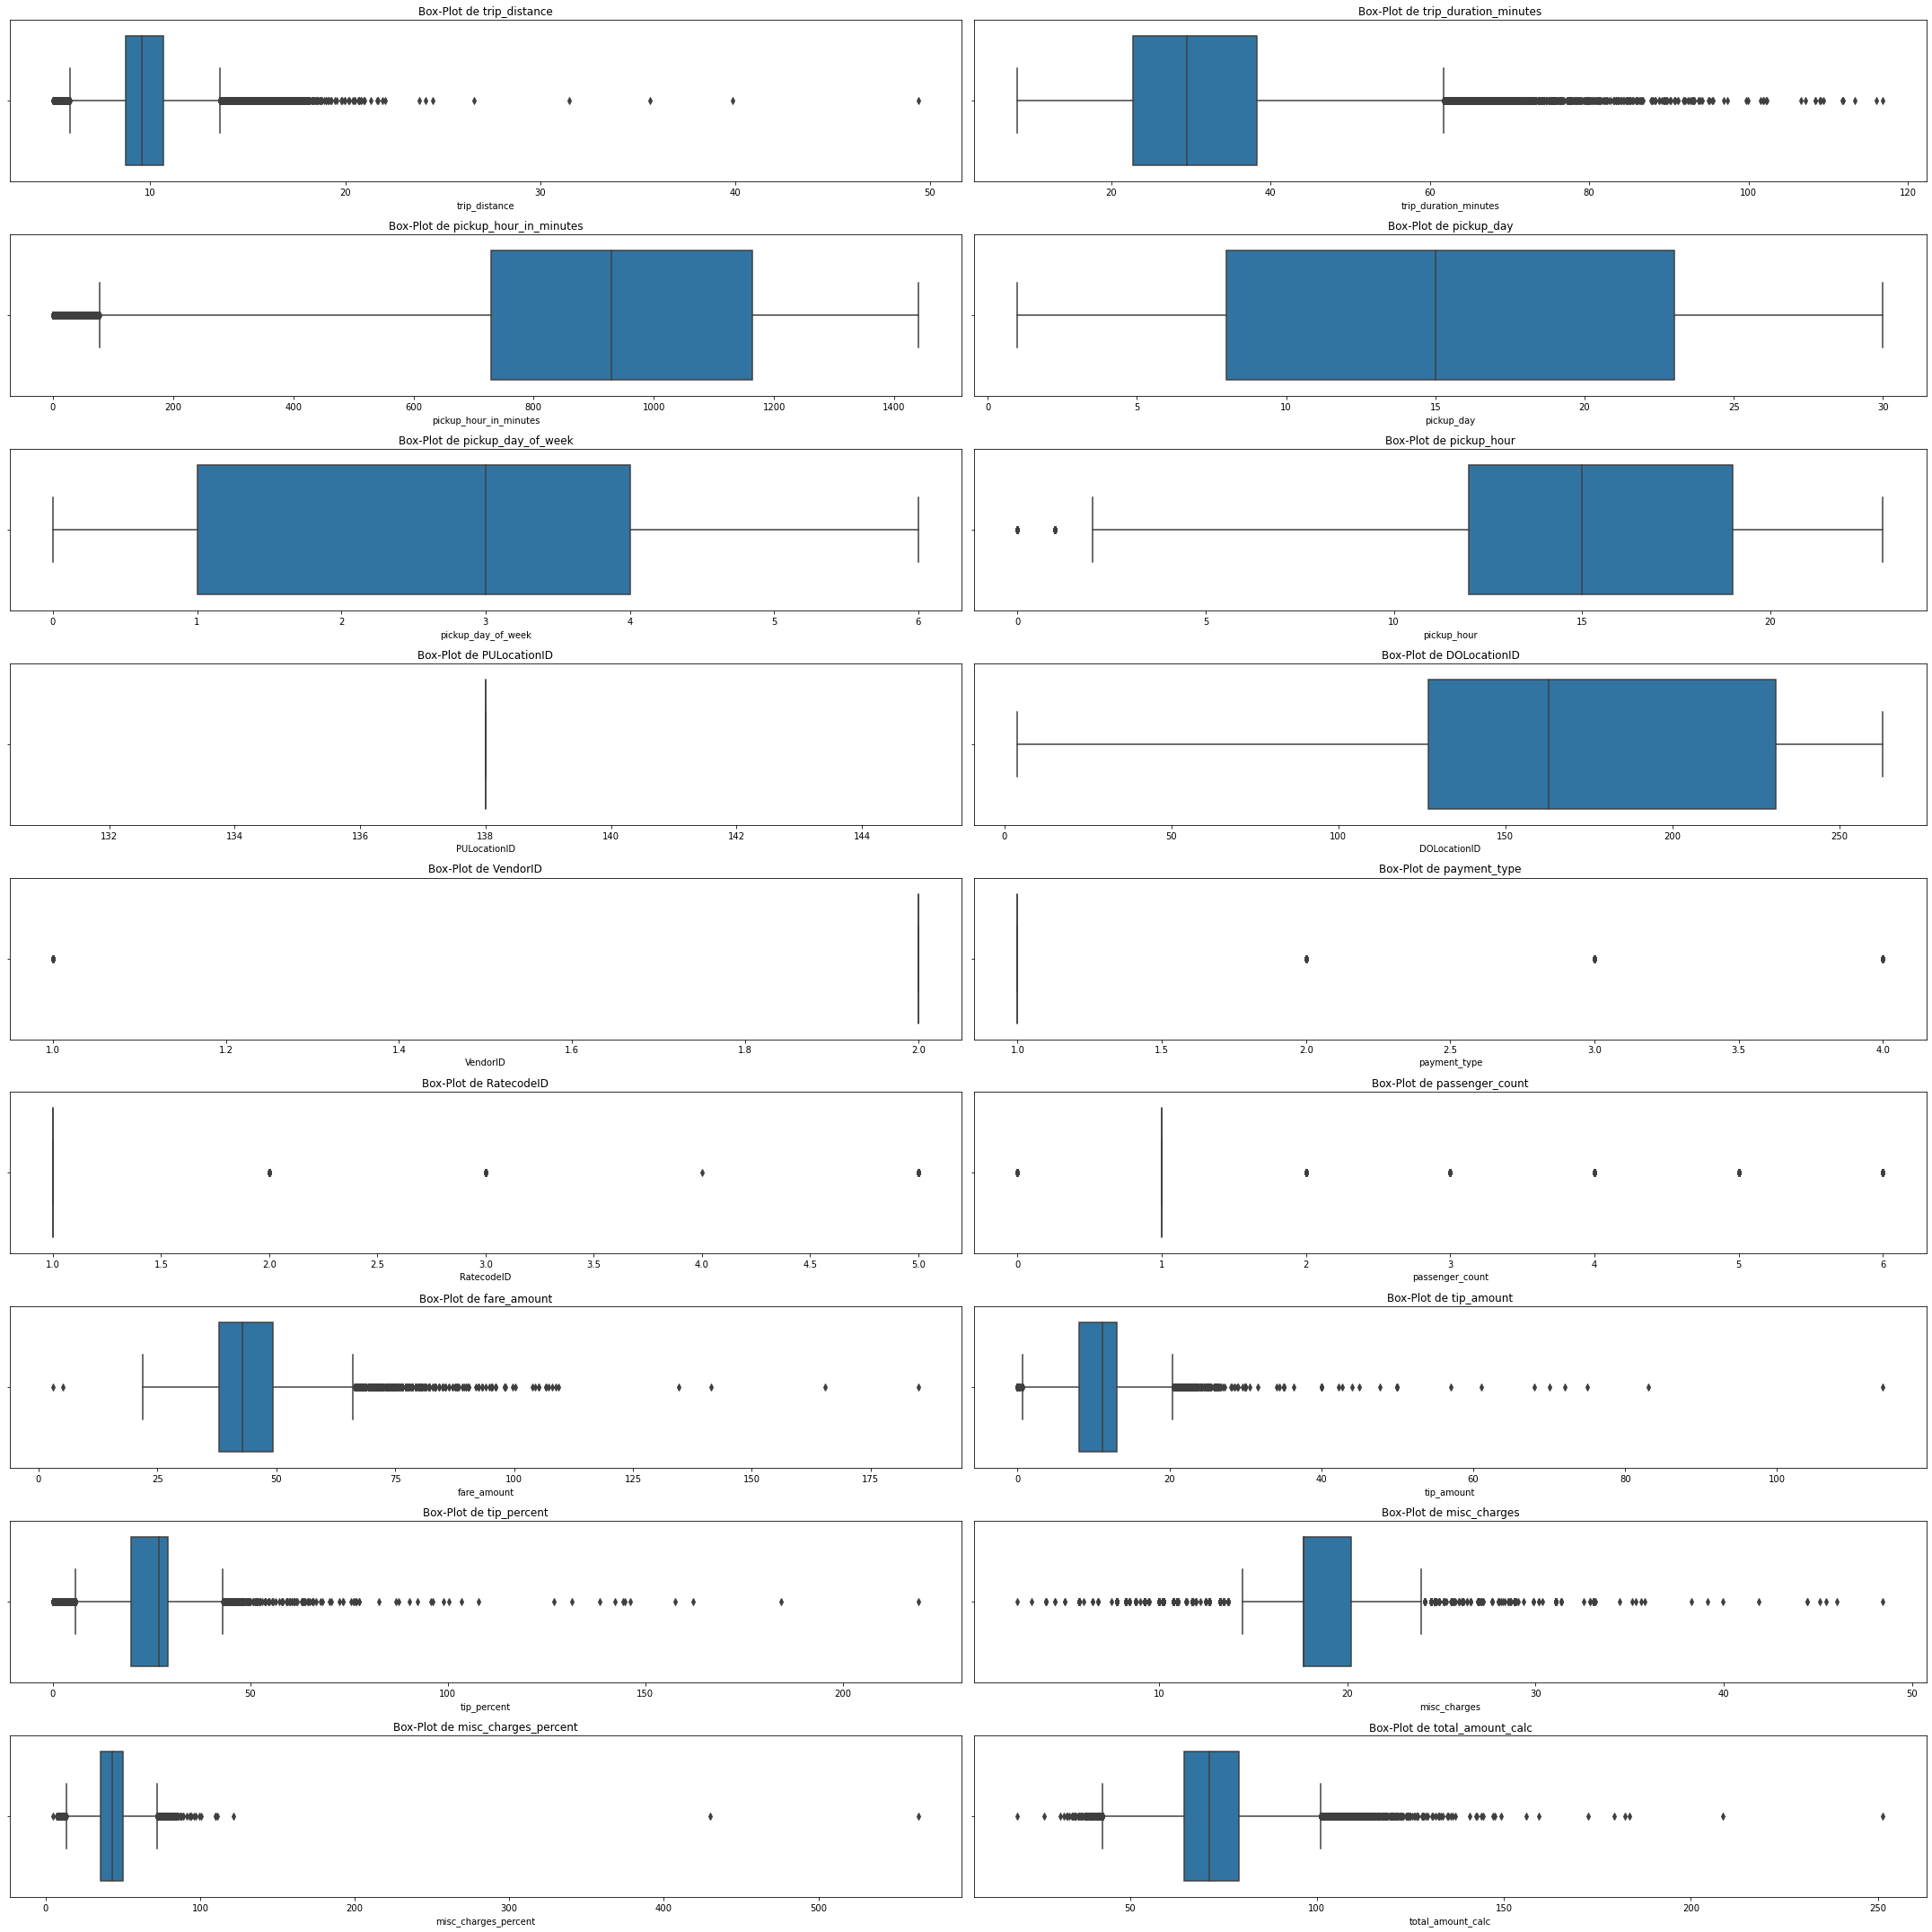

In [33]:
plt.figure(figsize=(30, 30))
n_cols = 2
n_rows = -(-len(variables_graficar) // n_cols)

for i, var in enumerate(variables_graficar, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[var])
    plt.title(f'Box-Plot de {var}')
    plt.xlabel(var)

plt.tight_layout()
plt.show()

In [34]:
stats_df = descriptive_stats(df, variables_graficar)
print("Estadísticas Descriptivas:")
print(stats_df)

Estadísticas Descriptivas:
        trip_distance  trip_duration_minutes  pickup_hour_in_minutes  \
Min              5.00                   8.23                    0.02   
Max             49.40                 116.88                 1439.98   
Median           9.56                  29.47                  929.08   
Mode             9.10                  23.90                  833.02   
Mean             9.88                  31.40                  929.63   
Std              1.79                  11.61                  295.59   
Count        76678.00               76678.00                76678.00   

        pickup_day  pickup_day_of_week  pickup_hour  PULocationID  \
Min           1.00                0.00         0.00        138.00   
Max          30.00                6.00        23.00        138.00   
Median       15.00                3.00        15.00        138.00   
Mode         15.00                0.00        14.00        138.00   
Mean         15.51                2.64        15.00

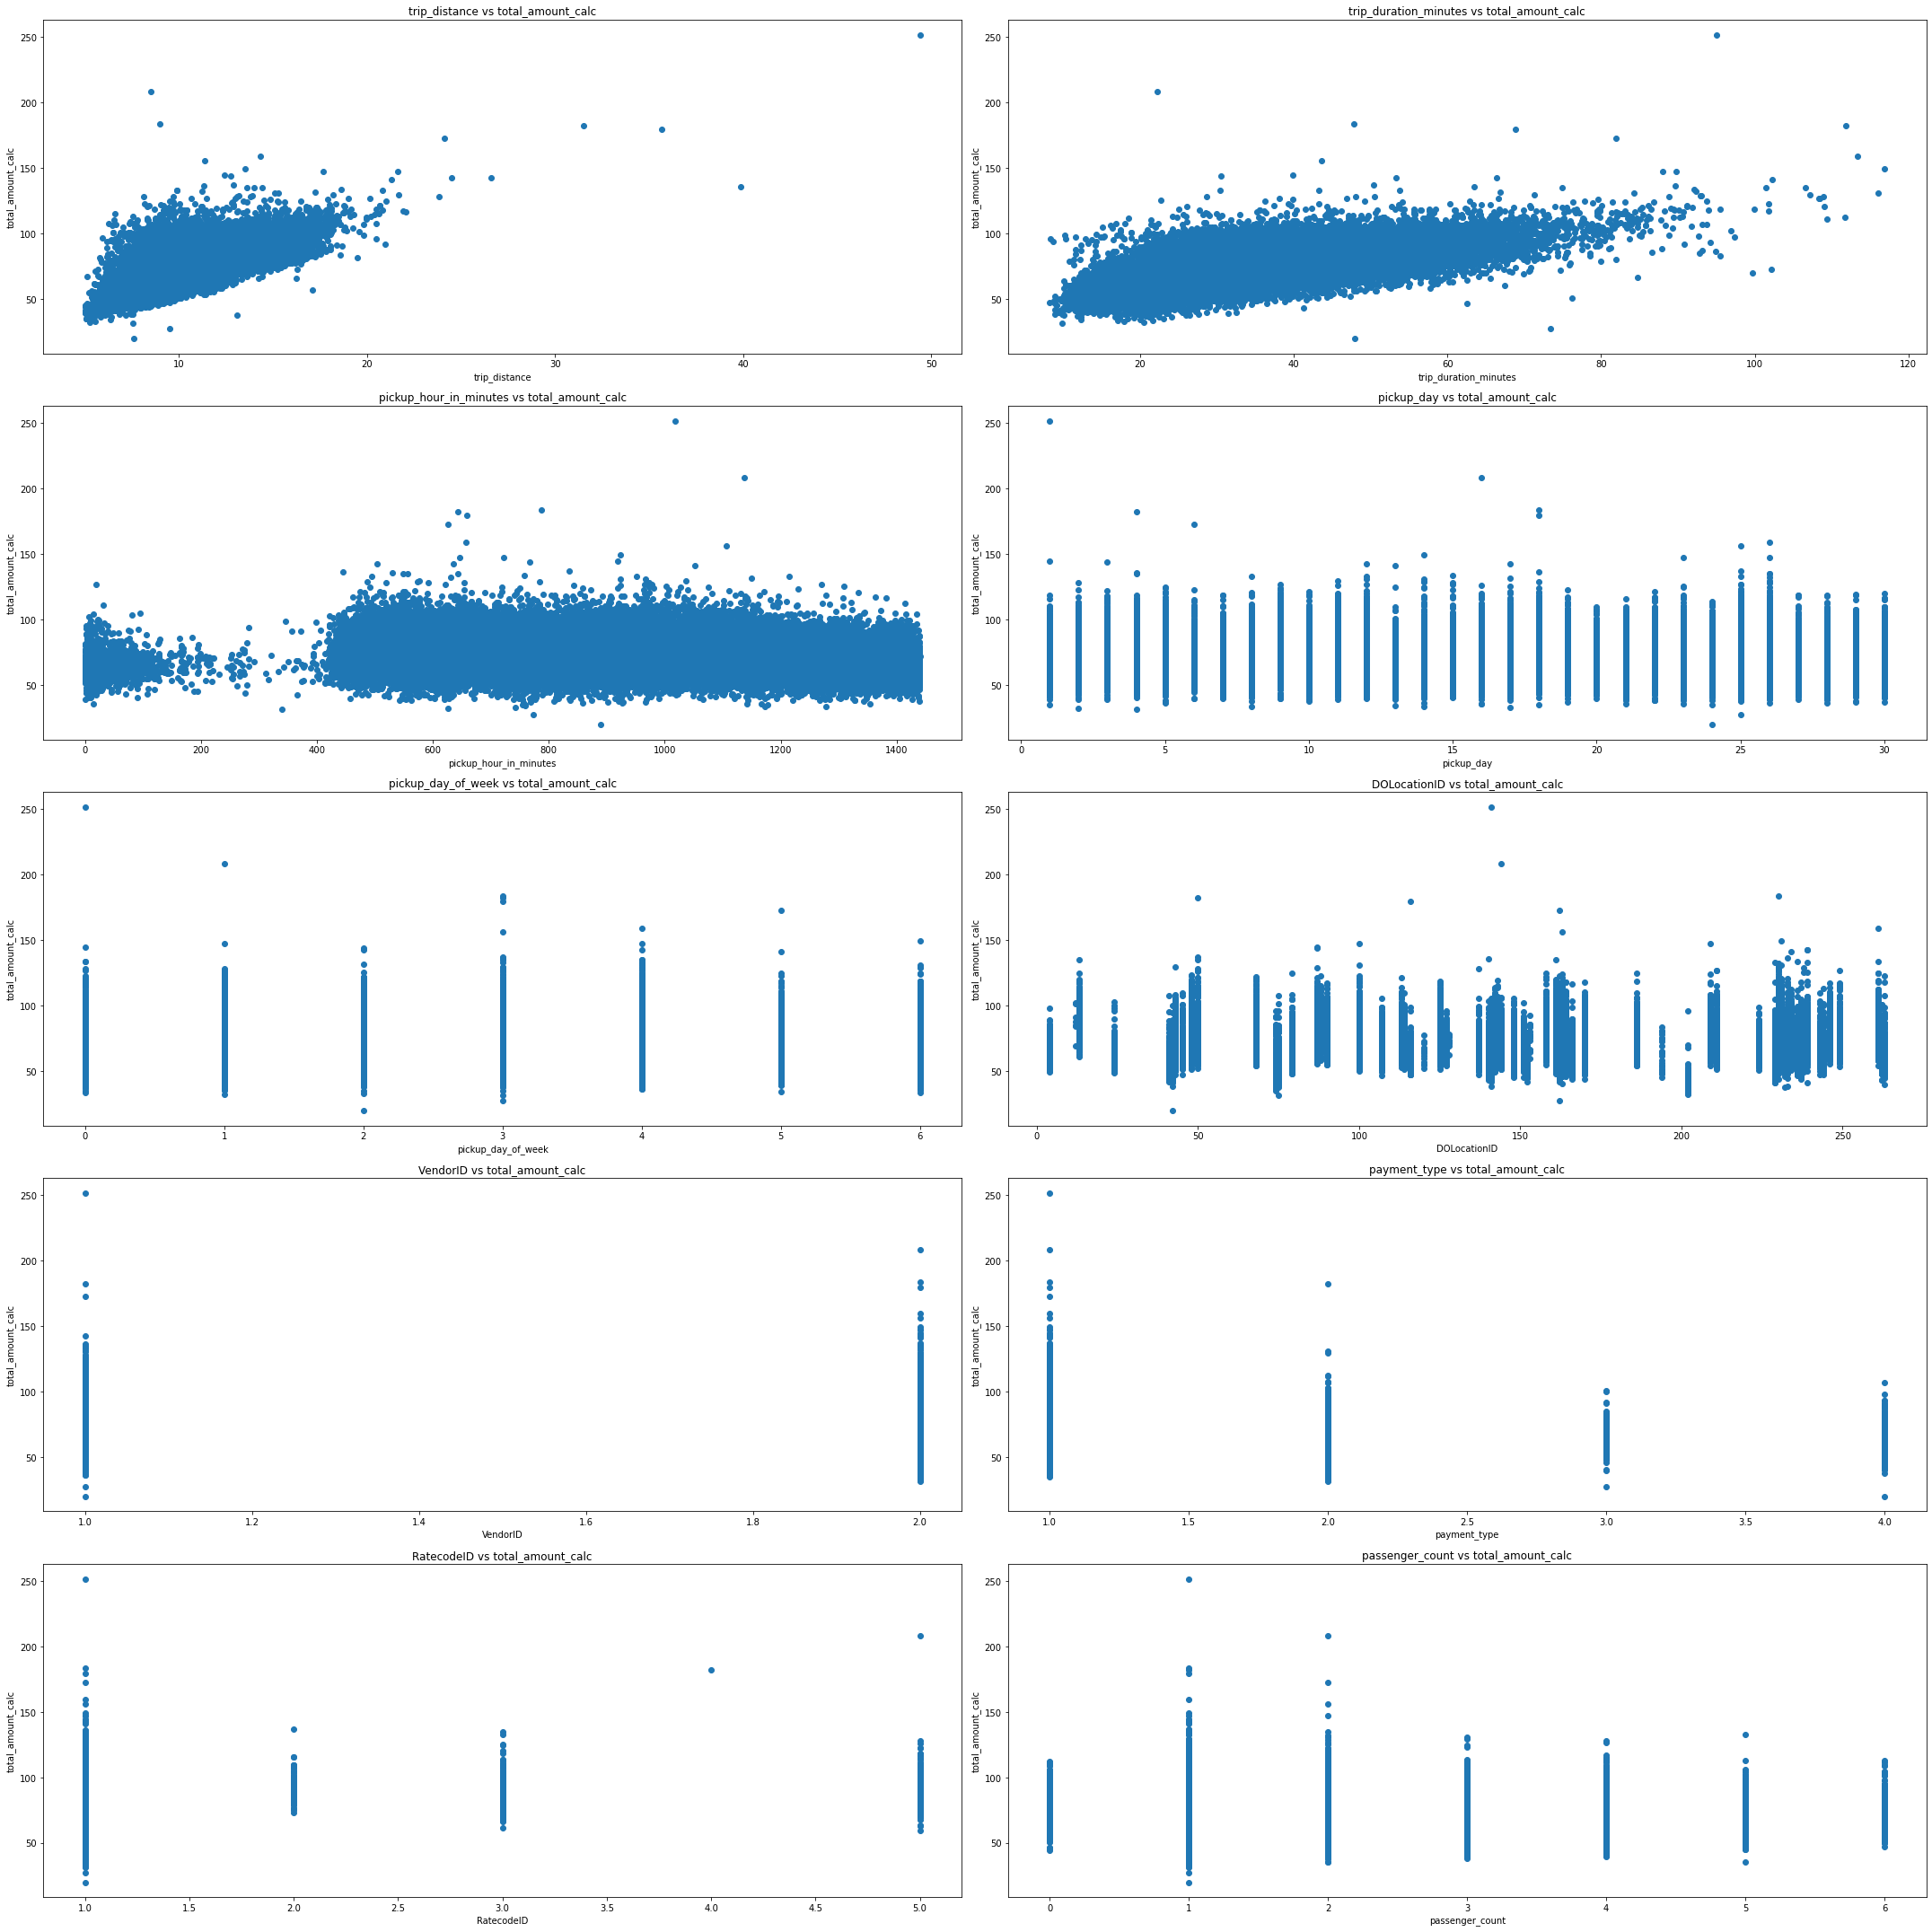

In [35]:
# Análisis exploratorio: Graficar cada variable vs total_amount
plt.figure(figsize=(30, 30))

n_cols = 2
n_rows = -(-len(variables_x_regresion) // n_cols)
for i, feature in enumerate(variables_x_regresion, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(df[feature], df[variable_y_regresion])
    plt.title(f'{feature} vs {variable_y_regresion}')
    plt.xlabel(feature)
    plt.ylabel(variable_y_regresion)

plt.tight_layout()
plt.show()

In [36]:
# https://gitlab.com/ppGodel/machine_learning/-/blob/master/classes/regression.org?ref_type=heads

import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from typing import Any, Dict, List, Tuple, Type, Union

def transform_variable(df: pd.DataFrame, x: str) -> pd.DataFrame:
    if pd.api.types.is_numeric_dtype(df[x]):
        return df[[x]]  # Devolver DataFrame en lugar de Serie
    else:
        return pd.DataFrame(np.arange(len(df)), columns=[x])

def split_train_test(df: pd.DataFrame, x_label: str, y_label: str, test_size: float = 0.3, random_state: int = 0) -> Tuple:
    fixed_x = transform_variable(df, x_label).values.reshape(-1, 1)
    y = df[y_label].values
    return train_test_split(fixed_x, y, test_size=test_size, random_state=random_state)

def train_model(x: np.ndarray, y: np.ndarray,
                model_class: Type[Union[LinearRegression, Ridge, Lasso, KNeighborsRegressor, DecisionTreeRegressor]],
                model_params: Dict[str, Any]) -> Union[LinearRegression, Ridge, Lasso, KNeighborsRegressor, DecisionTreeRegressor]:
    print(f"Using {model_class.__name__} with {model_params}")
    model = model_class(**model_params)
    trained_model = model.fit(x, y)
    return trained_model

def create_plot(subplots: int = 111) -> Tuple[plt.Figure, plt.Axes]:
    fig = plt.figure()
    ax = fig.add_subplot(subplots)
    return fig, ax

def plot_points(ax: plt.Axes, x: np.ndarray, y: np.ndarray, scatter_params: Dict[str, Any]):
    return ax.scatter(x, y, **scatter_params)


def plot_line(ax: plt.Axes, x: np.ndarray, y: np.ndarray, color: str, label: str = 'line'):
    return ax.plot(x, y, color=color, label=label)

def finalize_and_save(fig: plt.Figure, ax: plt.Axes, file_name: str, ylim: Tuple[float, float] = None,
                      rotation: int = 90, size_inches: Tuple[int, int] = (27, 18)):
    ax.tick_params(axis='x', labelrotation=rotation)
    fig.set_size_inches(*size_inches)
    if ylim is not None:
        ax.set_ylim(ylim)
    fig.savefig(file_name)
    plt.close()


In [37]:
def linear_regression_model(df: pd.DataFrame, x: str, y: str) -> None:
    print("----------------------------------------------")
    print("Using linear_regression_model")
    print(f"x: {x}, y: {y}")
    fixed_x, x_test, y_train, y_test = split_train_test(df, x, y)
    trained_model = train_model(fixed_x, y_train, LinearRegression, {})  # type: LinearRegression
    mean = [y_train.mean() for _ in range(len(fixed_x))]
    print(f"Coefficients: {trained_model.coef_} Intercept: {trained_model.intercept_}", flush=True)
    print(f"Mean: {mean[0]}", flush=True)
    print('R-squared score : {:.3f}'.format(trained_model.score(x_test, y_test)))

    fig, ax = create_plot()
    plot_points(ax, fixed_x, y_train, scatter_params={'marker': '.', 'c': 'blue'})
    plot_line(ax, fixed_x, trained_model.predict(fixed_x), color='red', label='Trained regression')
    plot_line(ax, fixed_x, mean, color='orange', label='Mean')
    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/a_lr_{y}_{x}.png', ylim=[min(y_train), max(y_train)])
    
linear_regression_model(df, "trip_duration_minutes", "total_amount_calc")
linear_regression_model(df, "trip_distance", "total_amount_calc")

----------------------------------------------
Using linear_regression_model
x: trip_duration_minutes, y: total_amount_calc
Using LinearRegression with {}
Coefficients: [0.6902089] Intercept: 50.7235524009336
Mean: 72.39378656332674
R-squared score : 0.480
----------------------------------------------
Using linear_regression_model
x: trip_distance, y: total_amount_calc
Using LinearRegression with {}
Coefficients: [4.52057369] Intercept: 27.716054114295375
Mean: 72.39378656332674
R-squared score : 0.487


In [38]:
def linear_regression_ridge_model(df: pd.DataFrame, x: str, y: str, alphas: List[int]) -> None:
    print("----------------------------------------------")
    print("Using linear_regression_ridge_model")
    print(f"x: {x}, y: {y}")
    fixed_x = transform_variable(df, x)
    fig, ax = create_plot()
    plot_points(ax, fixed_x.values.flatten(), df[y].values, scatter_params={'marker': '.', 'c': 'blue'})
    for index, alpha in enumerate(alphas):
        trained_model = train_model(fixed_x, df[y], Ridge, {'alpha': alpha})  # type: Ridge
        plot_line(ax, fixed_x.values.flatten(), trained_model.predict(fixed_x), color=f"C{index}", label=f"alpha {alpha}")
        print(f"alpha: {alpha} coeficients: {trained_model.coef_} intercept: {trained_model.intercept_}", flush=True)

    mean = np.full_like(df[y].values, df[y].mean())
    
    print(f"Mean: {mean[0]}", flush=True)
    # print('R-squared score : {:.3f}'.format(trained_model.score(x_test, y_test)))
    
    plot_line(ax, fixed_x.values.flatten(), mean, color=f"C{len(alphas)}", label='mean')
    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/b_lr_ridge_{y}_{x}.png', ylim=[df[y].min(), df[y].max()])

linear_regression_ridge_model(df, "trip_duration_minutes", "total_amount_calc", alphas=[0,1000, 10000])
linear_regression_ridge_model(df, "trip_distance", "total_amount_calc", alphas=[0,1000, 10000])

----------------------------------------------
Using linear_regression_ridge_model
x: trip_duration_minutes, y: total_amount_calc
Using Ridge with {'alpha': 0}
alpha: 0 coeficients: [0.69143851] intercept: 50.65471596284314
Using Ridge with {'alpha': 1000}
alpha: 1000 coeficients: [0.69137165] intercept: 50.65681509575549
Using Ridge with {'alpha': 10000}
alpha: 10000 coeficients: [0.69077053] intercept: 50.675689040701656
Mean: 72.36430710242833
----------------------------------------------
Using linear_regression_ridge_model
x: trip_distance, y: total_amount_calc
Using Ridge with {'alpha': 0}
alpha: 0 coeficients: [4.51498801] intercept: 27.74589171024632
Using Ridge with {'alpha': 1000}
alpha: 1000 coeficients: [4.49669118] intercept: 27.926706280915624
Using Ridge with {'alpha': 10000}
alpha: 10000 coeficients: [4.33845813] intercept: 29.49041098579996
Mean: 72.36430710242833


In [39]:
def linear_regression_ridge_model(df: pd.DataFrame, x: str, y: str, alphas: List[int]) -> None:
    print("----------------------------------------------")
    print("Using linear_regression_ridge_model v 2")
    print(f"x: {x}, y: {y}")
    fixed_x = transform_variable(df, x)
    fig, ax = create_plot()
    plot_points(ax, fixed_x.values.flatten(), df[y].values, scatter_params={'marker': '.', 'c': 'blue'})
    
    for index, alpha in enumerate(alphas):
        trained_model = train_model(fixed_x.values, df[y].values, Ridge, {'alpha': alpha})  # type: Ridge
        predictions = trained_model.predict(fixed_x.values)
        plot_line(ax, fixed_x.values.flatten(), predictions, color=f"C{index}", label=f"alpha {alpha}")
        
        r2 = r2_score(df[y].values, predictions)
        print(f"alpha: {alpha} coefficients: {trained_model.coef_} intercept: {trained_model.intercept_} R-squared score: {r2}", flush=True)

    mean = np.full_like(df[y].values, df[y].mean())
    print(f"Mean: {mean[0]}", flush=True)
    
    plot_line(ax, fixed_x.values.flatten(), mean, color=f"C{len(alphas)}", label='mean')
    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/b_lr_ridge_{y}_{x}.png', ylim=[df[y].min(), df[y].max()])

# Ejemplo de uso con los datos y variables correspondientes
linear_regression_ridge_model(df, "trip_duration_minutes", "total_amount_calc", alphas=[0,1000, 10000])
linear_regression_ridge_model(df, "trip_distance", "total_amount_calc", alphas=[0,1000, 10000])


----------------------------------------------
Using linear_regression_ridge_model v 2
x: trip_duration_minutes, y: total_amount_calc
Using Ridge with {'alpha': 0}
alpha: 0 coefficients: [0.69143851] intercept: 50.65471596284314 R-squared score: 0.4798527459713815
Using Ridge with {'alpha': 1000}
alpha: 1000 coefficients: [0.69137165] intercept: 50.65681509575549 R-squared score: 0.47985274148512025
Using Ridge with {'alpha': 10000}
alpha: 10000 coefficients: [0.69077053] intercept: 50.675689040701656 R-squared score: 0.4798522981250368
Mean: 72.36430710242833
----------------------------------------------
Using linear_regression_ridge_model v 2
x: trip_distance, y: total_amount_calc
Using Ridge with {'alpha': 0}
alpha: 0 coefficients: [4.51498801] intercept: 27.74589171024632 R-squared score: 0.4862521410822094
Using Ridge with {'alpha': 1000}
alpha: 1000 coefficients: [4.49669118] intercept: 27.926706280915624 R-squared score: 0.4862441556194096
Using Ridge with {'alpha': 10000}
alph

In [40]:
def linear_regression_lasso_model(df: pd.DataFrame, x: str, y: str, alphas: List[int]) -> None:
    print("----------------------------------------------")
    print("Using linear_regression_lasso_model")
    print(f"x: {x}, y: {y}")
    fixed_x = transform_variable(df, x)
    fig, ax = create_plot()
    plot_points(ax, fixed_x.values.flatten(), df[y].values, scatter_params={'marker': '.', 'c': 'blue'})
    for index, alpha in enumerate(alphas):
        if alpha == 0:
            print("Skipping alpha=0 since it's not suitable for Lasso. Use LinearRegression instead.")
            continue
        trained_model = train_model(fixed_x, df[y], Lasso, {'alpha': alpha})  # type: Lasso
        plot_line(ax, fixed_x.values.flatten(), trained_model.predict(fixed_x), color=f"C{index}", label=f"alpha {alpha}")
        print(f"alpha: {alpha} coeficients: {trained_model.coef_} intercept: {trained_model.intercept_}", flush=True)

    mean = np.full_like(df[y].values, df[y].mean())
    plot_line(ax, fixed_x.values.flatten(), mean, color=f"C{len(alphas)}", label='mean')
    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/c_lr_lasso_{y}_{x}.png', ylim=[df[y].min(), df[y].max()])


linear_regression_lasso_model(df, "trip_duration_minutes", "total_amount_calc", alphas=[0,10000000, 100000000])
linear_regression_lasso_model(df, "trip_distance", "total_amount_calc", alphas=[0,10000000, 100000000])


----------------------------------------------
Using linear_regression_lasso_model
x: trip_duration_minutes, y: total_amount_calc
Skipping alpha=0 since it's not suitable for Lasso. Use LinearRegression instead.
Using Lasso with {'alpha': 10000000}
alpha: 10000000 coeficients: [0.] intercept: 72.36430710242833
Using Lasso with {'alpha': 100000000}
alpha: 100000000 coeficients: [0.] intercept: 72.36430710242833
----------------------------------------------
Using linear_regression_lasso_model
x: trip_distance, y: total_amount_calc
Skipping alpha=0 since it's not suitable for Lasso. Use LinearRegression instead.
Using Lasso with {'alpha': 10000000}
alpha: 10000000 coeficients: [0.] intercept: 72.36430710242833
Using Lasso with {'alpha': 100000000}
alpha: 100000000 coeficients: [0.] intercept: 72.36430710242833


In [41]:
def polynomial_regression_model(df: pd.DataFrame, x: str, y: str, degrees: List[int]) -> None:
    print("----------------------------------------------")
    print("Using polynomial_regression_model")
    print(f"x: {x}, y: {y}")
    fixed_x = transform_variable(df, x)
    fig, ax = create_plot()
    plot_points(ax, fixed_x.values.flatten(), df[y].values, scatter_params={'marker': '.', 'c': 'blue'})
    for index, degree in enumerate(degrees):
        polynomial_transformer = PolynomialFeatures(degree=degree)
        X_transformed = polynomial_transformer.fit_transform(fixed_x)
        trained_model = train_model(X_transformed, df[y], LinearRegression, {})  # type: LinearRegression
        plot_line(ax, fixed_x.values.flatten(), trained_model.predict(X_transformed), color=f"C{index}", label=f"degree {degree}")
        print(f"coeficients: {trained_model.coef_} intercept: {trained_model.intercept_}", flush=True)

    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/d_pr_{y}_{x}.png', ylim=[min(df[y]), max(df[y])])

polynomial_regression_model(df, "trip_duration_minutes", "total_amount_calc",degrees=[1,2,5,8])
polynomial_regression_model(df, "trip_distance", "total_amount_calc",degrees=[1,2,5,8])

----------------------------------------------
Using polynomial_regression_model
x: trip_duration_minutes, y: total_amount_calc
Using LinearRegression with {}
coeficients: [0.         0.69143851] intercept: 50.65471596284293
Using LinearRegression with {}
coeficients: [ 0.          0.84561381 -0.00208259] intercept: 48.14788369989891
Using LinearRegression with {}
coeficients: [ 0.          2.24198972 -0.05606177  0.00093585 -0.00000759  0.00000002] intercept: 35.50107541989944
Using LinearRegression with {}
coeficients: [ 0.          0.01411975  0.16293138 -0.01047034  0.00033681 -0.00000616
  0.00000006 -0.          0.        ] intercept: 44.710926223209654
----------------------------------------------
Using polynomial_regression_model
x: trip_distance, y: total_amount_calc
Using LinearRegression with {}
coeficients: [0.         4.51498801] intercept: 27.745891710246248
Using LinearRegression with {}
coeficients: [ 0.          6.60077174 -0.09275166] intercept: 16.4889490512531
Usin

In [42]:
def polynomial_ridge_regression_model(df: pd.DataFrame, x: str, y: str, degrees: List[int], alphas: List[float]) -> None:
    print("----------------------------------------------")
    print("Using polynomial_ridge_regression_model")
    print(f"x: {x}, y: {y}")
    fixed_x = transform_variable(df, x)
    scaler = StandardScaler()
    fixed_x_scaled = scaler.fit_transform(fixed_x)

    fig, ax = create_plot()
    plot_points(ax, fixed_x.values.flatten(), df[y].values, scatter_params={'marker': '.', 'c': 'blue'})
    for degree_index, degree in enumerate(degrees):
        polynomial_transformer = PolynomialFeatures(degree=degree)
        X_transformed = polynomial_transformer.fit_transform(fixed_x_scaled)
        for alpha_index, alpha in enumerate(alphas):
            trained_model = train_model(X_transformed, df[y], Ridge, {'alpha': alpha})  # type: Ridge
            color_number = degree_index * len(alphas) + alpha_index
            plot_line(ax, fixed_x.values.flatten(), trained_model.predict(X_transformed), color=f"C{color_number}", label=f"degree {degree} alpha {alpha}")
            print(f"degree: {degree}, alpha: {alpha} coefficients: {trained_model.coef_} intercept: {trained_model.intercept_}", flush=True)

    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/e_pr_ridge_{y}_{x}.png', ylim=[df[y].min(), df[y].max()])


polynomial_ridge_regression_model(df, "trip_duration_minutes", "total_amount_calc",degrees=[8], alphas=[0,100,1000])
polynomial_ridge_regression_model(df, "trip_distance", "total_amount_calc",degrees=[8], alphas=[0,100,1000])


----------------------------------------------
Using polynomial_ridge_regression_model
x: trip_duration_minutes, y: total_amount_calc
Using Ridge with {'alpha': 0}
degree: 8, alpha: 0 coefficients: [ 0.          8.0320981  -0.47197068 -0.03206333 -0.08902509  0.11765103
 -0.03645283  0.00438873 -0.00018168] intercept: 72.90108058473312
Using Ridge with {'alpha': 100}
degree: 8, alpha: 100 coefficients: [ 0.          7.91655376 -0.46314643  0.07559079 -0.11691327  0.09791398
 -0.0265458   0.00285851 -0.0001025 ] intercept: 72.89638559881128
Using Ridge with {'alpha': 1000}
degree: 8, alpha: 1000 coefficients: [ 0.          7.10683924 -0.39016778  0.7984428  -0.30746085 -0.02994567
  0.03801206 -0.00709995  0.00041175] intercept: 72.8574947524297
----------------------------------------------
Using polynomial_ridge_regression_model
x: trip_distance, y: total_amount_calc
Using Ridge with {'alpha': 0}
degree: 8, alpha: 0 coefficients: [ 0.          8.6630064  -1.31802896  0.13526828  0.061

C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.96585e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\franc\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.96585e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [43]:
def polynomial_lasso_regression_model(df: pd.DataFrame, x: str, y: str, degrees: List[int], alphas: List[float]) -> None:
    print("----------------------------------------------")
    print("Using polynomial_lasso_regression_model")
    print(f"x: {x}, y: {y}")
    fixed_x = transform_variable(df, x)
    scaler = StandardScaler()
    fixed_x_scaled = scaler.fit_transform(fixed_x)

    fig, ax = create_plot()
    plot_points(ax, fixed_x.values.flatten(), df[y].values, scatter_params={'marker': '.', 'c': 'blue'})
    for degree_index, degree in enumerate(degrees):
        polynomial_transformer = PolynomialFeatures(degree=degree)
        X_transformed = polynomial_transformer.fit_transform(fixed_x_scaled)
        for alpha_index, alpha in enumerate(alphas):
            if alpha == 0:
                trained_model = train_model(X_transformed, df[y], LinearRegression, {})  # type: LinearRegression
            else:
                trained_model = train_model(X_transformed, df[y], Lasso, {'alpha': alpha})  # type: Lasso
            color_number = degree_index * len(alphas) + alpha_index
            plot_line(ax, fixed_x.values.flatten(), trained_model.predict(X_transformed), color=f"C{color_number}", label=f"degree {degree} alpha {alpha}")
            print(f"degree: {degree}, alpha: {alpha} coefficients: {trained_model.coef_} intercept: {trained_model.intercept_}", flush=True)

    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/f_pr_lasso_{y}_{x}.png', ylim=[df[y].min(), df[y].max()])


polynomial_lasso_regression_model(df, "trip_duration_minutes", "total_amount_calc",degrees=[8], alphas=[0,100000000,1000000000])
polynomial_lasso_regression_model(df, "trip_distance", "total_amount_calc",degrees=[8], alphas=[0,100000000,1000000000])


----------------------------------------------
Using polynomial_lasso_regression_model
x: trip_duration_minutes, y: total_amount_calc
Using LinearRegression with {}
degree: 8, alpha: 0 coefficients: [ 0.          8.0320981  -0.47197068 -0.03206333 -0.08902509  0.11765103
 -0.03645283  0.00438873 -0.00018168] intercept: 72.90108058471007
Using Lasso with {'alpha': 100000000}
degree: 8, alpha: 100000000 coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0.] intercept: 72.36430710242833
Using Lasso with {'alpha': 1000000000}
degree: 8, alpha: 1000000000 coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0.] intercept: 72.36430710242833
----------------------------------------------
Using polynomial_lasso_regression_model
x: trip_distance, y: total_amount_calc
Using LinearRegression with {}
degree: 8, alpha: 0 coefficients: [ 0.          8.66300628 -1.3180289   0.13526829  0.06110985 -0.01503918
  0.00139317 -0.00006008  0.00000099] intercept: 73.31848098777232
Using Lasso with {'alpha': 100000000}
degree: 8, alp

In [44]:
def linear_regression_model_predict(df: pd.DataFrame, x: str, y: str) -> None:
    print("----------------------------------------------")
    print("Using linear_regression_model_predict: sklearn lr model predict")
    print(f"x: {x}, y: {y}")
    X_train, X_test, y_train, y_test = split_train_test(df, x, y, test_size=0.3, random_state=0)
    trained_model = train_model(X_train, y_train, LinearRegression, {})  # type: LinearRegression
    coef, intercept = trained_model.coef_[0], trained_model.intercept_
    print(f"coef: {coef} intercept: {intercept}", flush=True)
    print('R-squared score (training): {:.9f}'.format(trained_model.score(X_train, y_train)))
    print('R-squared score (test): {:.9f}'.format(trained_model.score(X_test, y_test)))
    total_model = train_model(X_test, y_test, LinearRegression, {})  # type: LinearRegression
    total_coef, total_intercept = total_model.coef_[0], total_model.intercept_

    print('R-squared score total model (training): {:.9f}'.format(total_model.score(X_train, y_train)))
    print('R-squared score total model (test): {:.9f}'.format(total_model.score(X_test, y_test)))

    fig, ax = create_plot()
    plot_points(ax, X_train.flatten(), y_train, scatter_params={'marker': '.', 'c': 'blue', 'label': 'Train'})
    plot_points(ax, X_test.flatten(), y_test, scatter_params={'marker': 'x', 'c': 'orange', 'label': 'Test'})
    plot_line(ax, df[x].values, coef * df[x].values + intercept, color='blue', label='Trained regression')
    plot_line(ax, df[x].values, total_coef * df[x].values + total_intercept, color='green', label='Best regression')
    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/g_lr_model_{y}_{x}.png', ylim=[min(df[y]), max(df[y])])


linear_regression_model_predict(df, "trip_duration_minutes", "total_amount_calc")
linear_regression_model_predict(df, "trip_distance", "total_amount_calc")


----------------------------------------------
Using linear_regression_model_predict: sklearn lr model predict
x: trip_duration_minutes, y: total_amount_calc
Using LinearRegression with {}
coef: 0.6902089028200699 intercept: 50.7235524009336
R-squared score (training): 0.479712988
R-squared score (test): 0.480130314
Using LinearRegression with {}
R-squared score total model (training): 0.479620169
R-squared score total model (test): 0.480224316
----------------------------------------------
Using linear_regression_model_predict: sklearn lr model predict
x: trip_distance, y: total_amount_calc
Using LinearRegression with {}
coef: 4.5205736870623 intercept: 27.716054114295375
R-squared score (training): 0.485736975
R-squared score (test): 0.487431677
Using LinearRegression with {}
R-squared score total model (training): 0.485675644
R-squared score total model (test): 0.487494022


In [45]:
def KNN_regression_model(df: pd.DataFrame, x: str, y: str, neighbors: List[int]) -> None:
    print("----------------------------------------------")
    print("Using KNN_regression_model: sklearn with knn regression")
    print(f"x: {x}, y: {y}")
    fixed_x = transform_variable(df, x)
    fig, ax = create_plot()
    plot_points(ax, fixed_x.values.flatten(), df[y].values, scatter_params={'marker': '.', 'c': 'blue'})
    for index, n_neighbors in enumerate(neighbors):
        trained_model = train_model(fixed_x, df[y], KNeighborsRegressor, {'n_neighbors': n_neighbors})
        plot_line(ax, fixed_x.values.flatten(), trained_model.predict(fixed_x), color=f"C{index}", label=f"k{n_neighbors}")
    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/h_KNN_regression_{y}_{x}.png', ylim=[df[y].min(), df[y].max()])

# print_tabulate(df.tail(10))
KNN_regression_model(df, "trip_duration_minutes", "total_amount_calc", [1,3,5,10])
KNN_regression_model(df, "trip_distance", "total_amount_calc", [1,3,5,10])

----------------------------------------------
Using KNN_regression_model: sklearn with knn regression
x: trip_duration_minutes, y: total_amount_calc
Using KNeighborsRegressor with {'n_neighbors': 1}
Using KNeighborsRegressor with {'n_neighbors': 3}
Using KNeighborsRegressor with {'n_neighbors': 5}
Using KNeighborsRegressor with {'n_neighbors': 10}
----------------------------------------------
Using KNN_regression_model: sklearn with knn regression
x: trip_distance, y: total_amount_calc
Using KNeighborsRegressor with {'n_neighbors': 1}
Using KNeighborsRegressor with {'n_neighbors': 3}
Using KNeighborsRegressor with {'n_neighbors': 5}
Using KNeighborsRegressor with {'n_neighbors': 10}


----------------------------------------------
Using decision_tree_regression_model: sklearn with decision tree regression
x: trip_duration_minutes, y: total_amount_calc
Using DecisionTreeRegressor with {'random_state': 0, 'max_depth': 1, 'min_samples_leaf': 5}
Using DecisionTreeRegressor with {'random_state': 0, 'max_depth': 2, 'min_samples_leaf': 5}
Using DecisionTreeRegressor with {'random_state': 0, 'max_depth': 3, 'min_samples_leaf': 5}
Using DecisionTreeRegressor with {'random_state': 0, 'max_depth': 5, 'min_samples_leaf': 5}
Using DecisionTreeRegressor with {'random_state': 0, 'max_depth': 10, 'min_samples_leaf': 5}
----------------------------------------------
Using decision_tree_regression_model: sklearn with decision tree regression
x: trip_distance, y: total_amount_calc
Using DecisionTreeRegressor with {'random_state': 0, 'max_depth': 1, 'min_samples_leaf': 5}
Using DecisionTreeRegressor with {'random_state': 0, 'max_depth': 2, 'min_samples_leaf': 5}
Using DecisionTreeRegre

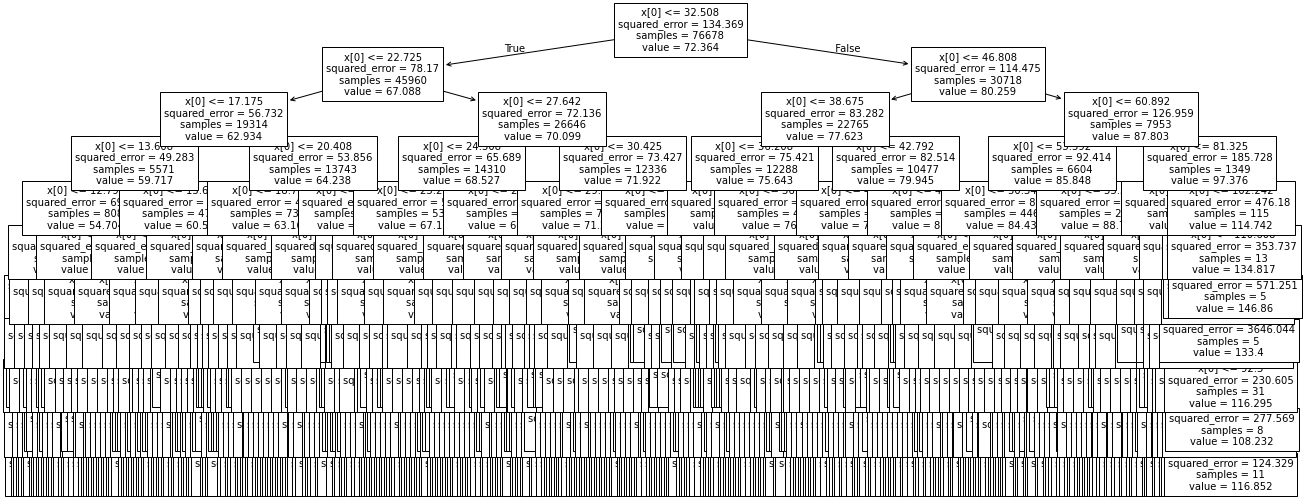

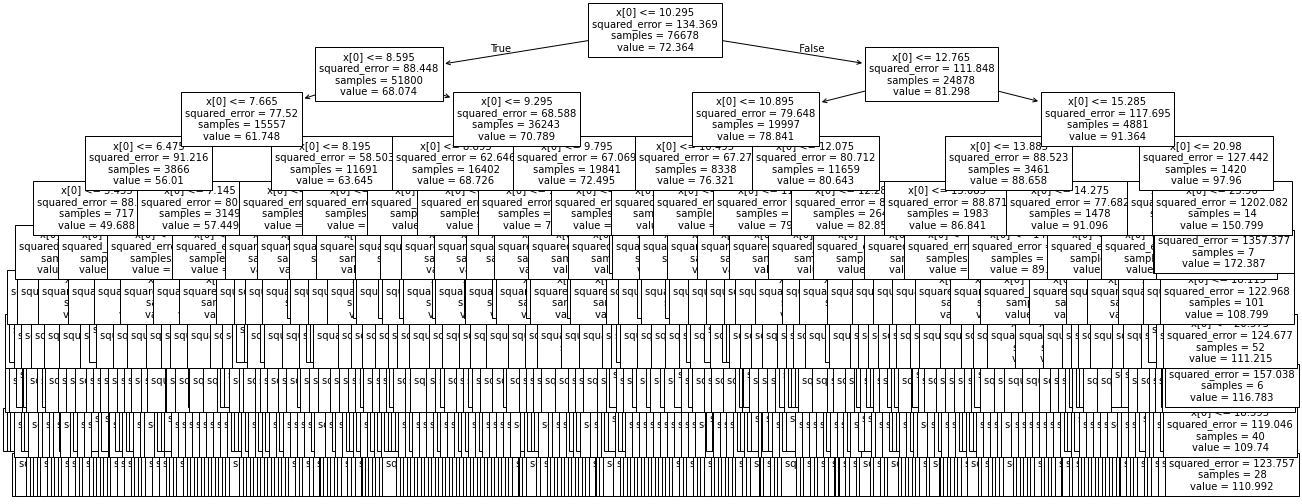

In [46]:
def decision_tree_regression_model(df: pd.DataFrame, x: str, y: str, depths: List[int]) -> None:
    print("----------------------------------------------")
    print("Using decision_tree_regression_model: sklearn with decision tree regression")
    print(f"x: {x}, y: {y}")
    fixed_x = transform_variable(df, x)
    fig, ax = create_plot()
    plot_points(ax, fixed_x.values.flatten(), df[y].values, scatter_params={'marker': '.', 'c': 'blue'})
    for index, max_depth in enumerate(depths):
        trained_model = train_model(fixed_x, df[y], DecisionTreeRegressor, {'random_state': 0, 'max_depth': max_depth, 'min_samples_leaf': 5})
        plot_line(ax, fixed_x.values.flatten(), trained_model.predict(fixed_x), color=f"C{index}", label=f"depth {max_depth}")
    ax.legend(loc="upper left")
    finalize_and_save(fig, ax, f'img/i_decision_tree_regression_{y}_{x}.png', ylim=[df[y].min(), df[y].max()])
    
    fig = plt.figure()
    plot_tree(trained_model, fontsize=10)
    fig.set_size_inches(21, 9)
    plt.savefig(f"img/j_decision_tree_{y}_{x}.png", bbox_inches="tight")

# print_tabulate(df.tail(10))
decision_tree_regression_model(df, "trip_duration_minutes", "total_amount_calc", [1,2,3,5,10])
decision_tree_regression_model(df, "trip_distance", "total_amount_calc", [1,2,3,5,10])


Timestamp: 2024-07-20 17:20:46.110540
Using Ridge Regression
Variables y Coeficientes:
trip_distance: 5.873173351480821
trip_duration_minutes: 5.964369841164797
pickup_hour_in_minutes: 0.4503432611092801
pickup_day: 0.09586198132054785
pickup_day_of_week: -0.5294007496177174
DOLocationID: 0.25038577992805133
VendorID: -1.3408990730302948
payment_type: -2.8899372282763776
RatecodeID: 1.8126907320841752
passenger_count: 0.013153476475715839
Intercept: 72.36968328784035
Mean: 72.36430710242833
R-squared score : 0.7942210003495883
Cross-Validation MSE: 27.22801015542992
Test MSE: 28.021607147320793
---
Timestamp: 2024-07-20 17:20:46.218526
Using Linear Regression
Variables y Coeficientes:
trip_distance: 5.87324280324683
trip_duration_minutes: 5.964453402191283
pickup_hour_in_minutes: 0.4503800845442364
pickup_day: 0.09586874971162745
pickup_day_of_week: -0.5294071826382786
DOLocationID: 0.25039947735689666
VendorID: -1.3409211911351535
payment_type: -2.8899868500695396
RatecodeID: 1.812724

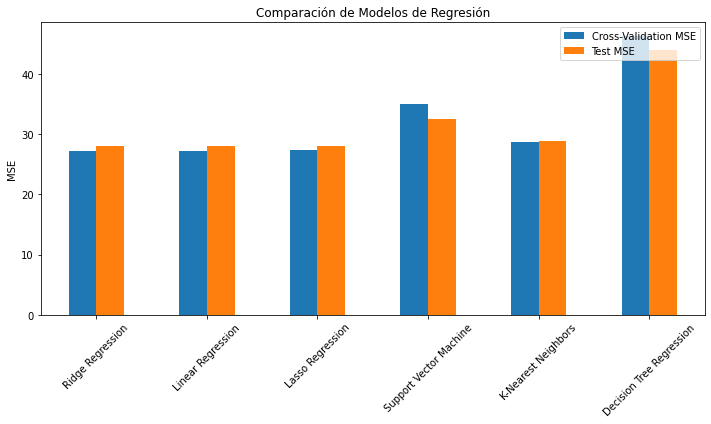


Mejor modelo: Ridge Regression
Cross-Validation MSE                                                27.23
Test MSE                                                            28.02
R-squared                                                            0.79
Mean Value                                                          72.36
Coefficients            [5.873173351480821, 5.964369841164797, 0.45034...
Intercept                                                           72.37
Name: Ridge Regression, dtype: object


In [47]:
# Modelos de Regresión
models_regression = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Support Vector Machine': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree Regression': DecisionTreeRegressor()
}

scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(df[variables_x_regresion])

results_regression = {}

X_reg = X_reg_scaled
y_reg = df[variable_y_regresion]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=17)

subsample_size = 10000
X_train_subsample, y_train_subsample = X_train_reg, y_train_reg

if len(X_train_reg) > subsample_size:
    random_indices = np.random.choice(len(X_train_reg), size=subsample_size, replace=False)
    X_train_subsample = X_train_reg[random_indices]
    y_train_subsample = y_train_reg.iloc[random_indices]

for name, model in models_regression.items():
    start_time = datetime.datetime.now()
    
    if name == 'Support Vector Machine':
        model.fit(X_train_subsample, y_train_subsample)
        cv_scores = cross_val_score(model, X_train_subsample, y_train_subsample, cv=5, scoring='neg_mean_squared_error')
    else:
        model.fit(X_train_reg, y_train_reg)
        cv_scores = cross_val_score(model, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_squared_error')
    
    mean_cv_score = -cv_scores.mean()
    
    y_pred_reg = model.predict(X_test_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    r_squared = model.score(X_test_reg, y_test_reg)
    mean_value = y_reg.mean()
    
    results_regression[name] = {
        'Cross-Validation MSE': mean_cv_score, 
        'Test MSE': mse, 
        'R-squared': r_squared, 
        'Mean Value': mean_value,
        'Coefficients': model.coef_ if hasattr(model, 'coef_') else 'N/A',
        'Intercept': model.intercept_ if hasattr(model, 'intercept_') else 'N/A'
    }
    
    end_time = datetime.datetime.now()
    print(f'Timestamp: {end_time}')
    print(f'Using {name}')
    if hasattr(model, 'coef_'):
        print("Variables y Coeficientes:")
        for var, coef in zip(variables_x_regresion, model.coef_):
            print(f'{var}: {coef}')
    print(f'Intercept: {results_regression[name]["Intercept"]}')
    print(f'Mean: {results_regression[name]["Mean Value"]}')
    print(f'R-squared score : {results_regression[name]["R-squared"]}')
    print(f'Cross-Validation MSE: {mean_cv_score}')
    print(f'Test MSE: {mse}')
    print('---')

results_regression_df = pd.DataFrame(results_regression).T
print(results_regression_df)

results_regression_df[['Cross-Validation MSE', 'Test MSE']].plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Modelos de Regresión')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

best_model = results_regression_df.loc[results_regression_df['R-squared'].idxmax()]
print(f'\nMejor modelo: {best_model.name}')
print(best_model)

Importancia de las Características en el Árbol de Decisión:
trip_distance            0.33
trip_duration_minutes    0.44
pickup_hour_in_minutes   0.04
pickup_day               0.02
pickup_day_of_week       0.01
DOLocationID             0.03
VendorID                 0.01
payment_type             0.07
RatecodeID               0.03
passenger_count          0.01
dtype: float64


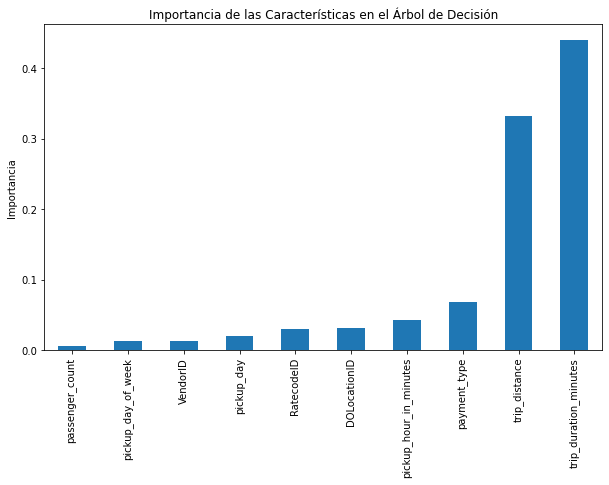

In [48]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_reg, y_train_reg)
importances = pd.Series(tree_reg.feature_importances_, index=variables_x_regresion)
print("Importancia de las Características en el Árbol de Decisión:")
print(importances)

plt.figure(figsize=(10, 6))
importances.sort_values().plot(kind='bar')
plt.title('Importancia de las Características en el Árbol de Decisión')
plt.ylabel('Importancia')
plt.show()